In [1]:
from sys import byteorder
from array import array
from struct import pack
import numpy as np
import matplotlib
import math
import scipy

import pyaudio
import wave


In [2]:
import sample
import matplotlib.pyplot as plt

In [3]:
def plotter(path):
    s = sample.Sample.from_file("data/{}".format(path))
    x,y = s.get_smooth_data()
    idx = 0
    while x[idx] < sample.BASE_CUTOFF:
        idx += 1
    x = x[idx:]
    y = y[idx:]
    plt.subplot(211)
    plt.plot(x,y,"-")
    x,y = s.get_data()
    plt.subplot(212)
    plt.plot(x,y,"-")
    plt.show()

3000.29296875
[9196, 9215, 9234, 9253, 9272, 9291, 9310, 9329, 9348, 9367, 9386, 9405, 9424, 9443, 9462, 9481, 9500, 9519, 9538, 9557, 9576, 9595, 9614, 9633, 9652, 9671, 9690, 9709, 9728, 9747, 9766, 9785, 9804, 9823, 9842, 9861, 9880, 9899, 9918, 9937, 9956, 9975, 9994, 10013, 10032, 10051, 10070, 10089, 10108, 10127, 10146, 10165, 10184, 10203, 10222, 10241, 10260, 10279, 10298, 10317, 10336, 10355, 10374, 10393, 10412, 10431, 10450, 10469, 10488, 10507, 10526, 10545, 10564, 10583, 10602, 10621, 10640, 10659, 10678, 10697, 10716, 10735, 10754, 10773, 10792, 10811, 10830, 10849, 10868, 10887, 10906, 10925, 10944, 10963, 10982, 11001, 11020, 11039, 11058, 11077, 11096, 11115, 11134, 11153, 11172, 11191, 11210, 11229, 11248, 11267, 11286, 11305, 11324, 11343, 11362, 11381, 11400, 11419, 11438, 11457, 11476, 11495, 11514, 11533, 11552, 11571, 11590, 11609, 11628, 11647, 11666, 11685, 11704, 11723, 11742, 11761, 11780, 11799, 11818, 11837, 11856, 11875, 11894, 11913, 11932, 11951, 11970,

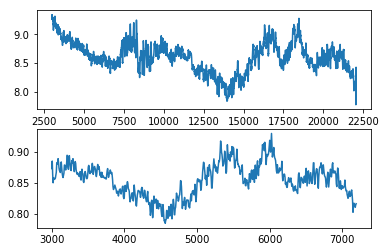

In [4]:
plotter("x-pad/0.wav")

3000.29296875
[9196, 9215, 9234, 9253, 9272, 9291, 9310, 9329, 9348, 9367, 9386, 9405, 9424, 9443, 9462, 9481, 9500, 9519, 9538, 9557, 9576, 9595, 9614, 9633, 9652, 9671, 9690, 9709, 9728, 9747, 9766, 9785, 9804, 9823, 9842, 9861, 9880, 9899, 9918, 9937, 9956, 9975, 9994, 10013, 10032, 10051, 10070, 10089, 10108, 10127, 10146, 10165, 10184, 10203, 10222, 10241, 10260, 10279, 10298, 10317, 10336, 10355, 10374, 10393, 10412, 10431, 10450, 10469, 10488, 10507, 10526, 10545, 10564, 10583, 10602, 10621, 10640, 10659, 10678, 10697, 10716, 10735, 10754, 10773, 10792, 10811, 10830, 10849, 10868, 10887, 10906, 10925, 10944, 10963, 10982, 11001, 11020, 11039, 11058, 11077, 11096, 11115, 11134, 11153, 11172, 11191, 11210, 11229, 11248, 11267, 11286, 11305, 11324, 11343, 11362, 11381, 11400, 11419, 11438, 11457, 11476, 11495, 11514, 11533, 11552, 11571, 11590, 11609, 11628, 11647, 11666, 11685, 11704, 11723, 11742, 11761, 11780, 11799, 11818, 11837, 11856, 11875, 11894, 11913, 11932, 11951, 11970,

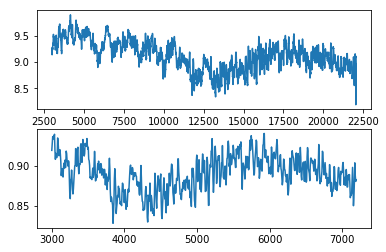

In [5]:
plotter("x-pad/4.wav")

3000.29296875
[9196, 9215, 9234, 9253, 9272, 9291, 9310, 9329, 9348, 9367, 9386, 9405, 9424, 9443, 9462, 9481, 9500, 9519, 9538, 9557, 9576, 9595, 9614, 9633, 9652, 9671, 9690, 9709, 9728, 9747, 9766, 9785, 9804, 9823, 9842, 9861, 9880, 9899, 9918, 9937, 9956, 9975, 9994, 10013, 10032, 10051, 10070, 10089, 10108, 10127, 10146, 10165, 10184, 10203, 10222, 10241, 10260, 10279, 10298, 10317, 10336, 10355, 10374, 10393, 10412, 10431, 10450, 10469, 10488, 10507, 10526, 10545, 10564, 10583, 10602, 10621, 10640, 10659, 10678, 10697, 10716, 10735, 10754, 10773, 10792, 10811, 10830, 10849, 10868, 10887, 10906, 10925, 10944, 10963, 10982, 11001, 11020, 11039, 11058, 11077, 11096, 11115, 11134, 11153, 11172, 11191, 11210, 11229, 11248, 11267, 11286, 11305, 11324, 11343, 11362, 11381, 11400, 11419, 11438, 11457, 11476, 11495, 11514, 11533, 11552, 11571, 11590, 11609, 11628, 11647, 11666, 11685, 11704, 11723, 11742, 11761, 11780, 11799, 11818, 11837, 11856, 11875, 11894, 11913, 11932, 11951, 11970,

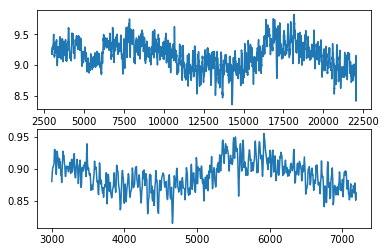

In [6]:
plotter("x-pad/6.wav")

3000.29296875
[9196, 9215, 9234, 9253, 9272, 9291, 9310, 9329, 9348, 9367, 9386, 9405, 9424, 9443, 9462, 9481, 9500, 9519, 9538, 9557, 9576, 9595, 9614, 9633, 9652, 9671, 9690, 9709, 9728, 9747, 9766, 9785, 9804, 9823, 9842, 9861, 9880, 9899, 9918, 9937, 9956, 9975, 9994, 10013, 10032, 10051, 10070, 10089, 10108, 10127, 10146, 10165, 10184, 10203, 10222, 10241, 10260, 10279, 10298, 10317, 10336, 10355, 10374, 10393, 10412, 10431, 10450, 10469, 10488, 10507, 10526, 10545, 10564, 10583, 10602, 10621, 10640, 10659, 10678, 10697, 10716, 10735, 10754, 10773, 10792, 10811, 10830, 10849, 10868, 10887, 10906, 10925, 10944, 10963, 10982, 11001, 11020, 11039, 11058, 11077, 11096, 11115, 11134, 11153, 11172, 11191, 11210, 11229, 11248, 11267, 11286, 11305, 11324, 11343, 11362, 11381, 11400, 11419, 11438, 11457, 11476, 11495, 11514, 11533, 11552, 11571, 11590, 11609, 11628, 11647, 11666, 11685, 11704, 11723, 11742, 11761, 11780, 11799, 11818, 11837, 11856, 11875, 11894, 11913, 11932, 11951, 11970,

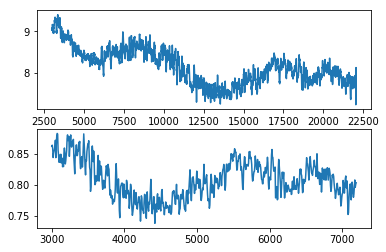

In [7]:
plotter("o-pad/3.wav")

3000.29296875
[9196, 9215, 9234, 9253, 9272, 9291, 9310, 9329, 9348, 9367, 9386, 9405, 9424, 9443, 9462, 9481, 9500, 9519, 9538, 9557, 9576, 9595, 9614, 9633, 9652, 9671, 9690, 9709, 9728, 9747, 9766, 9785, 9804, 9823, 9842, 9861, 9880, 9899, 9918, 9937, 9956, 9975, 9994, 10013, 10032, 10051, 10070, 10089, 10108, 10127, 10146, 10165, 10184, 10203, 10222, 10241, 10260, 10279, 10298, 10317, 10336, 10355, 10374, 10393, 10412, 10431, 10450, 10469, 10488, 10507, 10526, 10545, 10564, 10583, 10602, 10621, 10640, 10659, 10678, 10697, 10716, 10735, 10754, 10773, 10792, 10811, 10830, 10849, 10868, 10887, 10906, 10925, 10944, 10963, 10982, 11001, 11020, 11039, 11058, 11077, 11096, 11115, 11134, 11153, 11172, 11191, 11210, 11229, 11248, 11267, 11286, 11305, 11324, 11343, 11362, 11381, 11400, 11419, 11438, 11457, 11476, 11495, 11514, 11533, 11552, 11571, 11590, 11609, 11628, 11647, 11666, 11685, 11704, 11723, 11742, 11761, 11780, 11799, 11818, 11837, 11856, 11875, 11894, 11913, 11932, 11951, 11970,

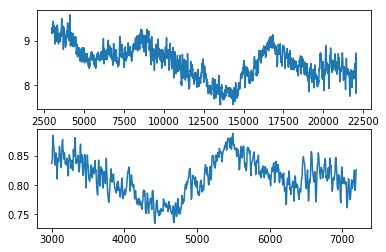

In [8]:
plotter("o-pad/8.wav")

3000.29296875
[9196, 9215, 9234, 9253, 9272, 9291, 9310, 9329, 9348, 9367, 9386, 9405, 9424, 9443, 9462, 9481, 9500, 9519, 9538, 9557, 9576, 9595, 9614, 9633, 9652, 9671, 9690, 9709, 9728, 9747, 9766, 9785, 9804, 9823, 9842, 9861, 9880, 9899, 9918, 9937, 9956, 9975, 9994, 10013, 10032, 10051, 10070, 10089, 10108, 10127, 10146, 10165, 10184, 10203, 10222, 10241, 10260, 10279, 10298, 10317, 10336, 10355, 10374, 10393, 10412, 10431, 10450, 10469, 10488, 10507, 10526, 10545, 10564, 10583, 10602, 10621, 10640, 10659, 10678, 10697, 10716, 10735, 10754, 10773, 10792, 10811, 10830, 10849, 10868, 10887, 10906, 10925, 10944, 10963, 10982, 11001, 11020, 11039, 11058, 11077, 11096, 11115, 11134, 11153, 11172, 11191, 11210, 11229, 11248, 11267, 11286, 11305, 11324, 11343, 11362, 11381, 11400, 11419, 11438, 11457, 11476, 11495, 11514, 11533, 11552, 11571, 11590, 11609, 11628, 11647, 11666, 11685, 11704, 11723, 11742, 11761, 11780, 11799, 11818, 11837, 11856, 11875, 11894, 11913, 11932, 11951, 11970,

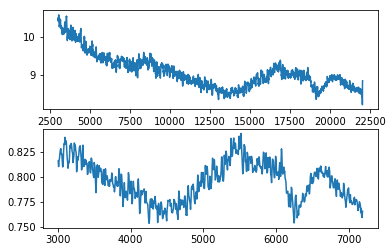

In [9]:
plotter("o-pad/14.wav")

3000.29296875
[9196, 9215, 9234, 9253, 9272, 9291, 9310, 9329, 9348, 9367, 9386, 9405, 9424, 9443, 9462, 9481, 9500, 9519, 9538, 9557, 9576, 9595, 9614, 9633, 9652, 9671, 9690, 9709, 9728, 9747, 9766, 9785, 9804, 9823, 9842, 9861, 9880, 9899, 9918, 9937, 9956, 9975, 9994, 10013, 10032, 10051, 10070, 10089, 10108, 10127, 10146, 10165, 10184, 10203, 10222, 10241, 10260, 10279, 10298, 10317, 10336, 10355, 10374, 10393, 10412, 10431, 10450, 10469, 10488, 10507, 10526, 10545, 10564, 10583, 10602, 10621, 10640, 10659, 10678, 10697, 10716, 10735, 10754, 10773, 10792, 10811, 10830, 10849, 10868, 10887, 10906, 10925, 10944, 10963, 10982, 11001, 11020, 11039, 11058, 11077, 11096, 11115, 11134, 11153, 11172, 11191, 11210, 11229, 11248, 11267, 11286, 11305, 11324, 11343, 11362, 11381, 11400, 11419, 11438, 11457, 11476, 11495, 11514, 11533, 11552, 11571, 11590, 11609, 11628, 11647, 11666, 11685, 11704, 11723, 11742, 11761, 11780, 11799, 11818, 11837, 11856, 11875, 11894, 11913, 11932, 11951, 11970,

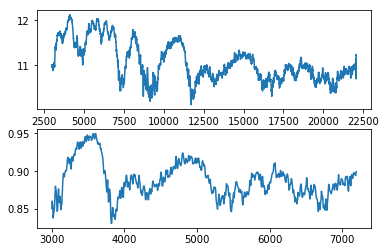

In [10]:
plotter("x-nail/7.wav")

3000.29296875
[9196, 9215, 9234, 9253, 9272, 9291, 9310, 9329, 9348, 9367, 9386, 9405, 9424, 9443, 9462, 9481, 9500, 9519, 9538, 9557, 9576, 9595, 9614, 9633, 9652, 9671, 9690, 9709, 9728, 9747, 9766, 9785, 9804, 9823, 9842, 9861, 9880, 9899, 9918, 9937, 9956, 9975, 9994, 10013, 10032, 10051, 10070, 10089, 10108, 10127, 10146, 10165, 10184, 10203, 10222, 10241, 10260, 10279, 10298, 10317, 10336, 10355, 10374, 10393, 10412, 10431, 10450, 10469, 10488, 10507, 10526, 10545, 10564, 10583, 10602, 10621, 10640, 10659, 10678, 10697, 10716, 10735, 10754, 10773, 10792, 10811, 10830, 10849, 10868, 10887, 10906, 10925, 10944, 10963, 10982, 11001, 11020, 11039, 11058, 11077, 11096, 11115, 11134, 11153, 11172, 11191, 11210, 11229, 11248, 11267, 11286, 11305, 11324, 11343, 11362, 11381, 11400, 11419, 11438, 11457, 11476, 11495, 11514, 11533, 11552, 11571, 11590, 11609, 11628, 11647, 11666, 11685, 11704, 11723, 11742, 11761, 11780, 11799, 11818, 11837, 11856, 11875, 11894, 11913, 11932, 11951, 11970,

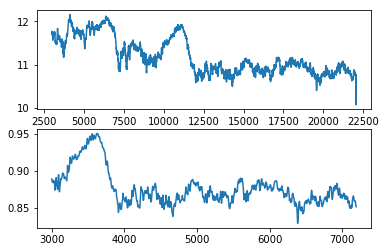

In [11]:
plotter("x-nail/10.wav")

3000.29296875
[9196, 9215, 9234, 9253, 9272, 9291, 9310, 9329, 9348, 9367, 9386, 9405, 9424, 9443, 9462, 9481, 9500, 9519, 9538, 9557, 9576, 9595, 9614, 9633, 9652, 9671, 9690, 9709, 9728, 9747, 9766, 9785, 9804, 9823, 9842, 9861, 9880, 9899, 9918, 9937, 9956, 9975, 9994, 10013, 10032, 10051, 10070, 10089, 10108, 10127, 10146, 10165, 10184, 10203, 10222, 10241, 10260, 10279, 10298, 10317, 10336, 10355, 10374, 10393, 10412, 10431, 10450, 10469, 10488, 10507, 10526, 10545, 10564, 10583, 10602, 10621, 10640, 10659, 10678, 10697, 10716, 10735, 10754, 10773, 10792, 10811, 10830, 10849, 10868, 10887, 10906, 10925, 10944, 10963, 10982, 11001, 11020, 11039, 11058, 11077, 11096, 11115, 11134, 11153, 11172, 11191, 11210, 11229, 11248, 11267, 11286, 11305, 11324, 11343, 11362, 11381, 11400, 11419, 11438, 11457, 11476, 11495, 11514, 11533, 11552, 11571, 11590, 11609, 11628, 11647, 11666, 11685, 11704, 11723, 11742, 11761, 11780, 11799, 11818, 11837, 11856, 11875, 11894, 11913, 11932, 11951, 11970,

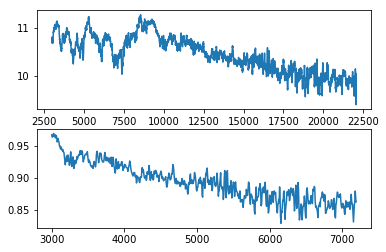

In [12]:
plotter("x-nail/14.wav")